In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from stop_words import get_stop_words
sns.set()
%matplotlib inline 

# Creacion de un Regresor
Para resolver el problema planteado, es necesario utilizar regresion lineal para obtener los descriptores de la imagen. Entre las multiples librerias disponibles para realizar esta tarea se opto por utilizar keras. Con keras, basta con definir una MLP donde la ultima capa no aplique ningun activador ni un soft-max. Para simplificar el contenido de este notebook, hemos implementado nuestro regresor en una libreria a parte, desde la cual importamos lo siguiente:

In [2]:
from src.regressor import Regressor, plot_metrics, r_square, rmse

Using TensorFlow backend.


Es posible ver los metodos definidos dentro al utilizar la funcion python help o accediendo directamente a la carpeta contenedora del codigo que sera adjuntada con la entrega.

Para agilizar el proceso, todos los regresores que se utilizaran en la obtencion de los indicadores seran cargados desde disco. Pero a continuacion mostraremos el procedimiento necesario para entrenar un nuevo modelo, incluyendo la verificacion de overfitting y el guardar el modelo resultante a disco.

### Calculo de los descriptores de texto
El primer paso es obtener los vectores que describen cada una de las 100000 frases contenidas en el set de entrenamiento. Se implementan dos alternativas para este procedimiento:
* CountVectorizer: ....
* TF-IDF: ...

Ambas alternativas deben ser configuradas por medio de una serie de parametros. Varias estos parametros sera priordial al momento de entrenar distintos Regressores.

Nuevamente, todo el codigo relativo a esta implementacion es creada en un codigo python externo a este notebook y debe ser importada de la siguiente manera:

In [7]:
from src.filehandler import DataHandler

En esta seccion, se creara un Regresor utilizando TF-IDF como generador de vectores. La configuracion a utilizar sera:
* ngram-range = (1, 3)
* stop-words = spanish

In [8]:
stop_words = get_stop_words('spanish')
# debemos indicar el directorio que contiene los datos y los sub-directorios que contienen cada dataset
data = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
# y obtenemos nuestros vectores
X_train, X_test, y_train, y_test = data.get_data(method="tf-idf", stop_words=stop_words, ngram_range=(1, 3))
print("shapes")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_A_data/test_A_images_names.txt
leyendo ./data/test_A_data/test_A_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with TfidfVectorizer
fitting ...done
getting vectors transforms ...done
shapes
X_train: (100000, 640)
y_train: (100000, 2048)
X_test: (5000, 640)
y_test: (5000, 2048)


Luego creamos un regressor para este tamaño de vectores, con dos capas escondidas, cada una de 200 neuronas. Adicionalmente, se utilizada la configuracionÑ
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True


Adicionalmente, se implementa un Early Stopping con una paciencia de 4 epocas y que monitorea el loss de validacion, de forma que cuando deje de decrecer o empiece a aumentar, detenga el entrenamiento y evite un overfitting. Ademas, se monitorea la metrica de MAE (mean absolute error), RMSE (root mean square error) y R-square.

In [9]:
in_dim = X_train.shape[1]
out_dim = y_train.shape[1]
reg = Regressor(input_dim=in_dim, output_dim=out_dim, n=2, layer_size=200, 
                loss='mean_squared_error', optimizer='adam', metrics=['mae', rmse, r_square])
reg.build()
history = reg.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               128200    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              411648    
Total params: 580,048
Trainable params: 580,048
Non-trainable params: 0
_________________________________________________________________
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 6s 76us/step - loss: 0.6440 - mean_absolute_error: 0.4863 - rmse: 0.7907 - r_square: 0.1230 - val_loss: 0.5643 - val_mean_absolute_error: 0.4579 - val_rmse: 0.7396 - val_r_square: 0.2334
Epoch 2/100
80000/80000 [==============================] - 5s 68us/step - loss: 0.5444 - mean_absolute_e

Como se observa al ejecutar la celda de arriba, entrenar el modelo entrega informacion sobre las metricas al terminar cada epoca y se detiene cuando el loss deja de bajar. Es posible observar las metricas o evaluar el modelo en otro data-set, ejecutando la siguiente celda:

evaluando test
5000/5000 [==============================] - 0s 45us/step
    EVALUATION RESULTS :  
loss: 0.52
mean_absolute_error: 0.44
rmse: 0.70
r_square: 0.30


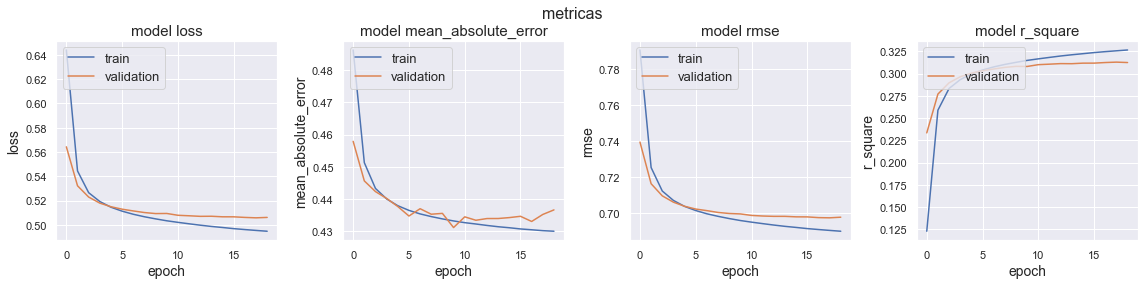

In [10]:
# graficar las metricas
reg.plot_metrics()

# evaluar el modelo
scores = reg.evaluate(X_test, y_test)

Por ultimo, el modelo debe ser guardado si se desea utilizarlo para situaciones posteriores, esto se realiza muy facilmente de la siguiente forma:

saving model to disk ... done!
loading model from disk ... done!
evaluando test
5000/5000 [==============================] - 0s 77us/step
    EVALUATION RESULTS :  
loss: 0.52
mean_absolute_error: 0.44
rmse: 0.70
r_square: 0.30


(<Figure size 1152x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B8C5D915F8>,
       dtype=object))

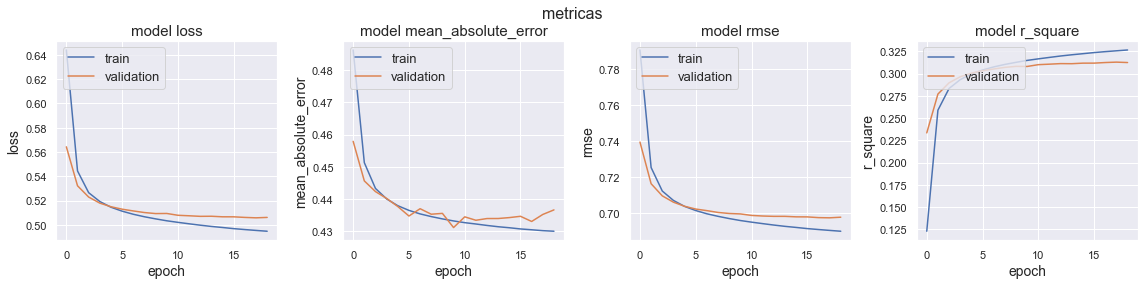

In [11]:
reg.save("test")
# se puede verificar esto al cargar el modelo en una nueva variable
reg2 = Regressor()
reg2.load("test", custom_objects={"rmse": rmse, "r_square": r_square})
# y veamos que evaluar el conjunto de test da los mismos resultados
score2 = reg2.evaluate(X_test, y_test)

# graficar las metricas
reg2.plot_metrics()

### Casos de estudio
Para este trabajo se opto por fijar una arquitectura para el regresor y estudiar diversas configuraciones en la obtencion de los descriptores de texto. La arquitectura comun para todos los casos de estudio sera la misma que fue utilizada en el ejemplo de arriba, en particular:

* capas internas:
    * fully-connected de 200 neuronas con activador ReLu
    * fully-connected de 200 neuronas con activador ReLu
* capa de salida: fully-connected de 2048 sin activador
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True
* Early Stopping : tolerancia de 0.005, con una paciencia de 4 epochas
* metricas monitoreadas : Mean Absolute Error, Root Mean Square Error, R-Square


Luego, los casos de estudio seran:

* Count-vectorizer con ngram_range = (1,1) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y con stop_words de español
* TF-IDF con ngram_range = (1,1) y sin stop_words
* TF-IDF con ngram_range = (1,4) y sin stop_words
* TF-IDF con ngram_range = (1,4) y con stop_words de español

Los regresores para cada uno de estos modelos se encuentran almacenados en la carpeta /model con nombres descriptivos de cada configuracion, de forma que puedan ser cargados facilmente.

A continuacion se presentan graficos de cada uno de estos regressores para asegurar que ninguno de ellos presente overffiting.

loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!


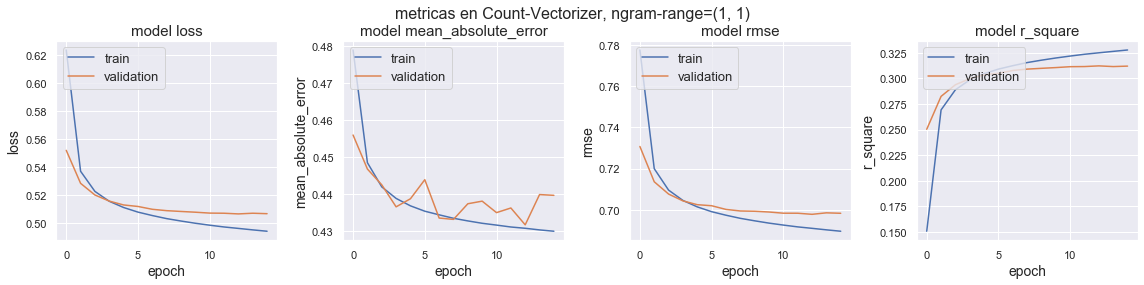

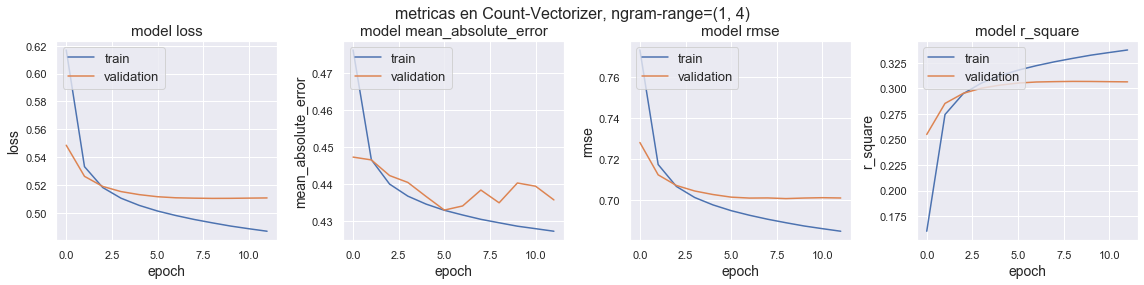

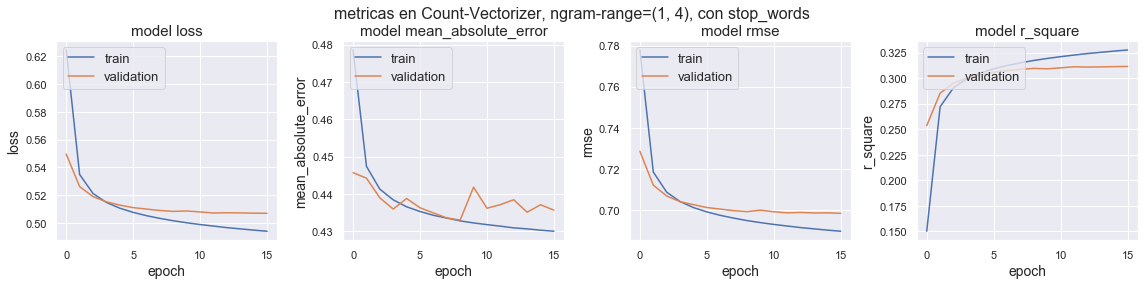

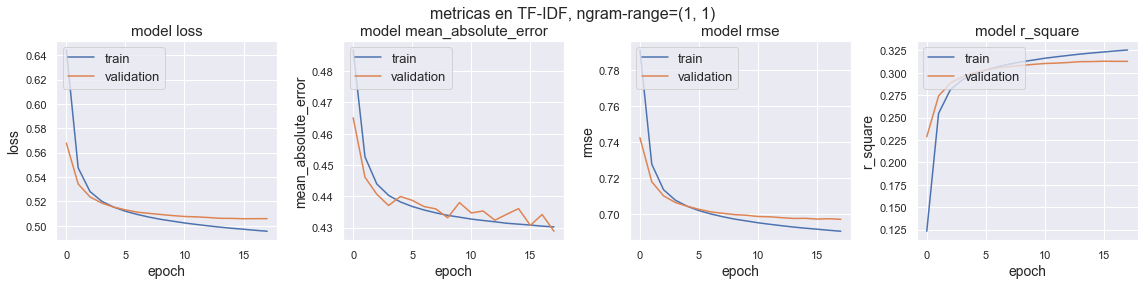

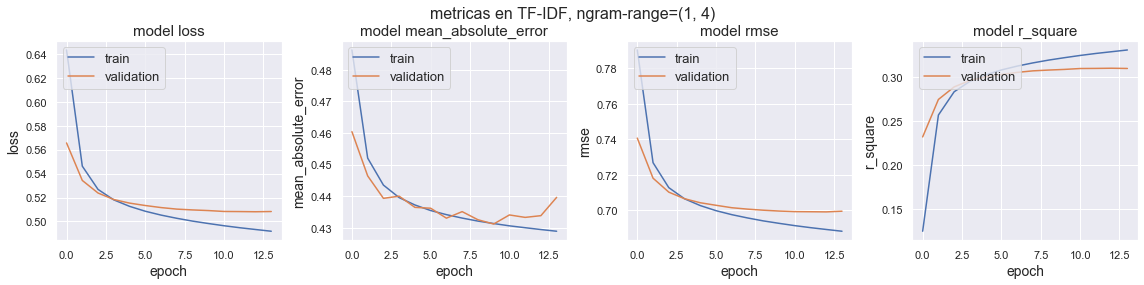

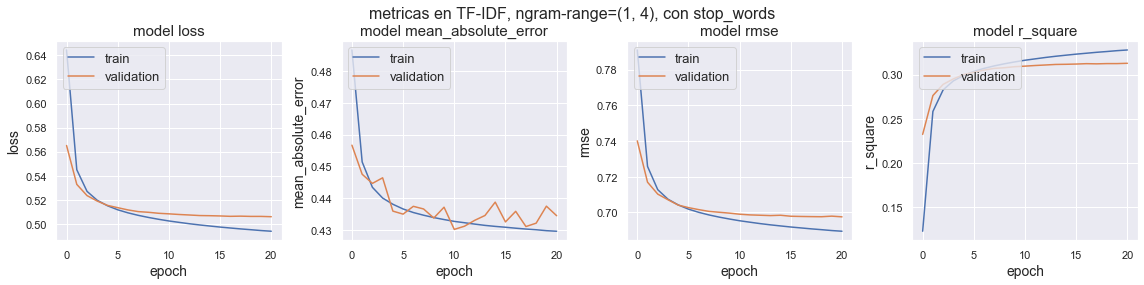

In [4]:
reg = Regressor()
reg.load("cv_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 1)")
reg.load("cv_ngram14_none", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 4)")
reg.load("cv_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 4), con stop_words")

reg.load("tf_idf_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg.plot_metrics("metricas en TF-IDF, ngram-range=(1, 1)")
reg.load("tf_idf_ngram14_none", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg.plot_metrics("metricas en TF-IDF, ngram-range=(1, 4)")
reg.load("tf_idf_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg.plot_metrics("metricas en TF-IDF, ngram-range=(1, 4), con stop_words")

In [5]:
reg["history"]

{'val_loss': [0.5494926518201828,
  0.5261386275291443,
  0.5189196291565895,
  0.5151713356375694,
  0.5128150388598443,
  0.5110082986950875,
  0.5099338668584824,
  0.5089489075541497,
  0.5082888516783715,
  0.5085936290025711,
  0.5078830525279046,
  0.5071213108301162,
  0.5073237651586533,
  0.5072030338644982,
  0.5070032766461372,
  0.5069112399220467],
 'val_mean_absolute_error': [0.4456696280837059,
  0.444204751253128,
  0.4389332190155983,
  0.4359290263056755,
  0.43876481771469117,
  0.4362794375419617,
  0.43489874213933943,
  0.4335659098625183,
  0.43298809975385666,
  0.4417965930700302,
  0.43614982306957245,
  0.43711279779672624,
  0.4384254613518715,
  0.4350857165455818,
  0.43708017706871033,
  0.4356452029943466],
 'val_rmse': [0.7285568398237229,
  0.7120962566137314,
  0.7068330144882202,
  0.7040245872735977,
  0.7026007336378097,
  0.7012118464708328,
  0.7004364401102066,
  0.6996826273202896,
  0.6992045670747757,
  0.6999192547798156,
  0.69913723051548

In [ ]:
reg[""]